# Preprocessing Data
This notebook is used for preprocessing and cleaning the .wav files by using the helper functions in `plot.py` and `calculations.py`. We also see visualizations of MFCCs and Time/frequency series.

In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile
import librosa
from python_speech_features import logfbank, mfcc

from util import calc_fft, calc_envelope_signal, plot_data

## Constants
Here are some constants that are used. They can be changed at the developer's discretion of the data.

In [2]:
RAW_DATA = "raw_wavfiles"
CLEAN_DATA = "clean_wavfiles"
RAW_CSV = "instruments.csv"
TRAIN_CSV = "train.csv"
SAMPLE_THRESHOLD = 0.005
SAMPLING_RATE = 16000

## Data Visualization
First, we need to visualize the data to see what we need to clean.

### Naive Class Distribution
Although the data has an equal class distribution as shown below, different wavfiles have different lengths, so purely looking at the number of wavfiles per class is not repesentative of the class distribution.

In [3]:
df = pd.read_csv(RAW_CSV)
df.set_index("fname", inplace=True)

df.label.value_counts()

Saxophone           30
Double_bass         30
Clarinet            30
Acoustic_guitar     30
Cello               30
Snare_drum          30
Bass_drum           30
Flute               30
Violin_or_fiddle    30
Hi-hat              30
Name: label, dtype: int64

To find the length of each wavfile, we can use `scipy`. `scipy` has a method called `wavfile.read()` that returns the sample rate of the wavfile and the actual samples of the wavfile in the form of a numpy array. The length of the numpy array is the number of samples in a wavfile while the sample rate repesents the number of samples per second in the wavfile. From these two values, we can calculate the length of the wavfile in seconds. We can show this using unit division:

$$\frac{samples}{\frac{samples}{second}} = samples * \frac{second}{samples} = second$$

We can see that we end with second, which is the unit for the length of the wavfiles.


In [4]:
for fname in df.index:
    sample_rate, samples = wavfile.read(os.path.join(RAW_DATA, fname))
    df.at[fname, "length"] = len(samples) / sample_rate

df.head()

,label,length
fname,,
5388d14d.wav,Saxophone,4.14
c685f05f.wav,Saxophone,1.54
36d20ab5.wav,Saxophone,4.90
d6665734.wav,Saxophone,10.50
7352e28f.wav,Saxophone,6.24


### True Class Distribution
Now that we have calculated the length of each wavfile, we can see the true class distribution. Since length is a continuous value, we determine the percentage of each class's weight by finding the mean of the lengths.

In [5]:
categories_dist = df.groupby(["label"])["length"].mean()
categories_dist

label
Acoustic_guitar     6.948667
Bass_drum           1.937333
Cello               5.000667
Clarinet            6.596000
Double_bass         3.206000
Flute               8.054667
Hi-hat              3.357333
Saxophone           7.124000
Snare_drum          3.987333
Violin_or_fiddle    4.530000
Name: length, dtype: float64

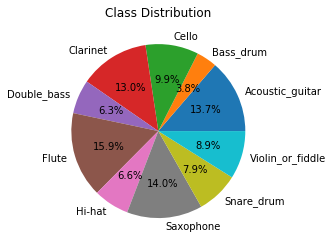

In [6]:
fig, ax = plt.subplots()
ax.set_title("Class Distribution")
ax.pie(categories_dist, labels=categories_dist.index, autopct="%0.1f%%")

plt.show()

## Preparing Data for Visualization
We create a dictionary for each graph/plot we are visualizing. In each dictionary, the keys are the instrument classes while the values are the values for the respective plot. Here are the dictionaries that we will be creating:

- `signals`: Time series visualization - Raw/Uncleaned data
- `clean_signals`: Time series visualization - Clean data by noise threshold filtering
- `fft`: Fourier Transform/Frequency Domain visualization 
- `fbank`: Filter bank coefficient visualization
- `mfccs`: Mels Cepstrum coefficient visualization

More information on the functions that produce the plot values are in `calculations.py`.

In [7]:
signals = {}
clean_signals = {}
fft = {}
fbank = {}
mfccs = {}

categories = list(np.unique(df.label))

for category in categories:
    wav = df[df.label == category].index[0]
    signal, sampling_rate = librosa.load(os.path.join(RAW_DATA, wav))
    signals[category] = signal
    
    # Apply a boolean mask to the signal numpy array to cut off dead sound space
    clean_signals[category] = signal[calc_envelope_signal(signal, sampling_rate, SAMPLE_THRESHOLD)]
    
    fft[category] = calc_fft(signal, sampling_rate)
    
    # Take transpose for neater plotting
    fbank[category] = logfbank(signal[:sampling_rate], samplerate=sampling_rate, nfft=1103).T
    mfccs[category] = mfcc(signal[:sampling_rate], samplerate=sampling_rate, nfft=1103).T

## Time Series (Raw Data)
In the following time series, we see that there are a lot of dead sound spaces. This would affect the accuracy of the model, so we remove this by applying a boolean mask with a sample threshold.

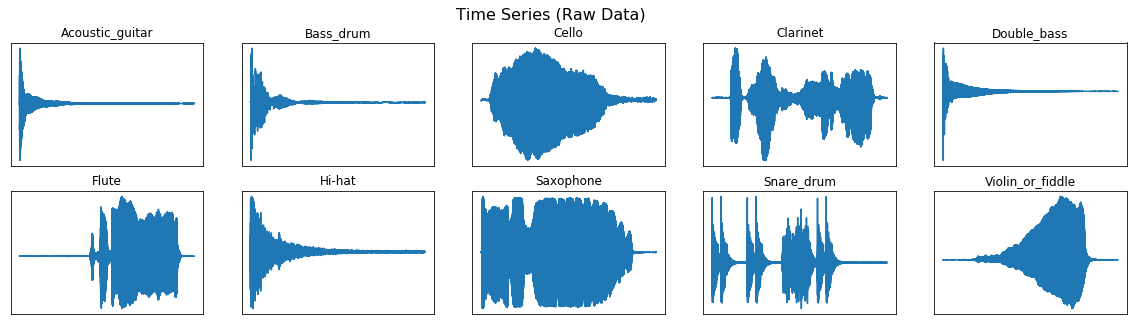

In [8]:
plot_data(signals, "Time Series (Raw Data)")

## Time Series (Clean Data)
In the following time series, we plot the data that has been cleaned of dead sound space. We can see that there is significantly less dead sound space in this series compared to the one above.

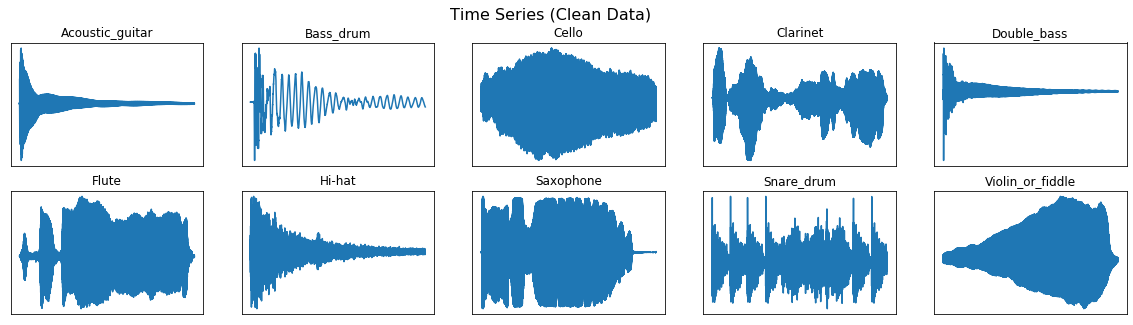

In [9]:
plot_data(clean_signals, "Time Series (Clean Data)")

## Fourier Transforms (Frequency Domain)

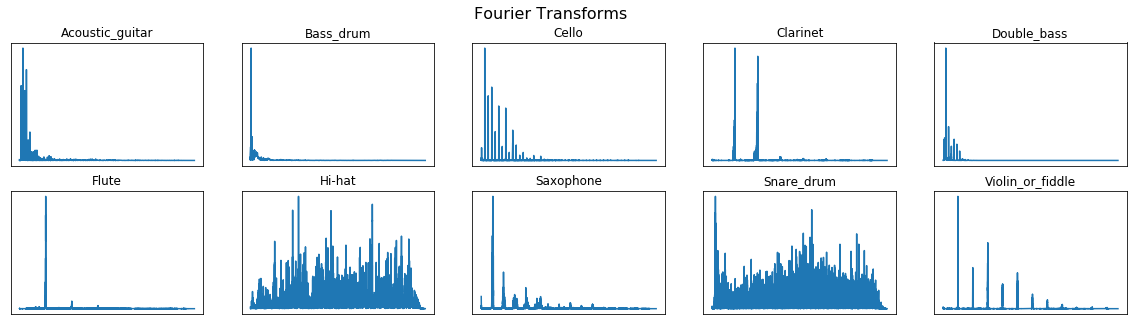

In [10]:
plot_data(fft, "Fourier Transforms")

## Filter Bank Coefficient

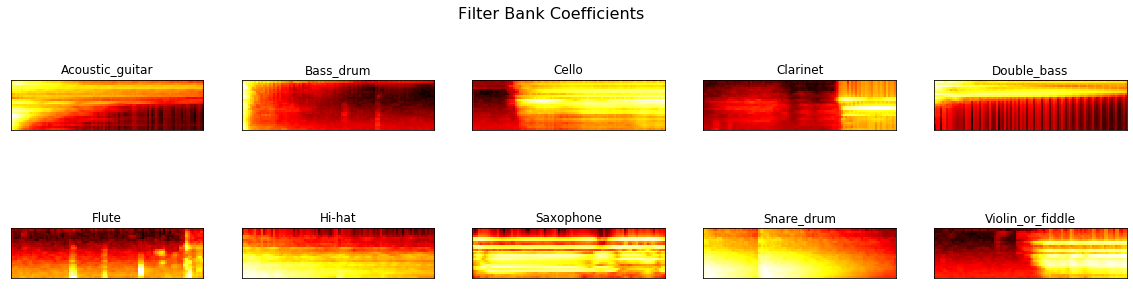

In [11]:
plot_data(fbank, "Filter Bank Coefficients", cmap="hot", interpolation="nearest")

## Mels Cepstrum Coefficient
We will be using MFCCs to predict wavfiles.

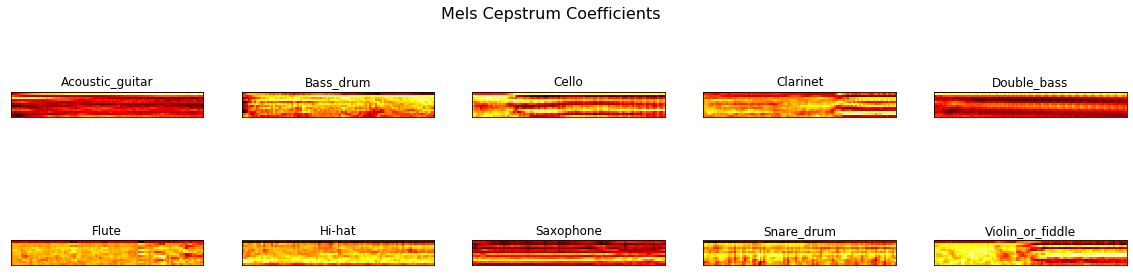

In [12]:
plot_data(mfccs, "Mels Cepstrum Coefficients", cmap="hot", interpolation="nearest")

## Creating Clean Wavfiles
Now, we output clean data into a separate directory for training preparation.

In [14]:
os.mkdir(CLEAN_DATA)

for fname in tqdm(df.index):
    signal, sampling_rate = librosa.load(os.path.join(RAW_DATA, fname), sr=SAMPLING_RATE) # Downsampling
    wavfile.write(
        os.path.join(CLEAN_DATA, fname), 
        sampling_rate, 
        signal[calc_envelope_signal(signal, sampling_rate, SAMPLE_THRESHOLD)]
    )

100%|██████████| 300/300 [01:10<00:00,  4.28it/s]


## Categories Distribution for Clean Data
As a final visualization, we see the class distribution for the cleaned data.

In [15]:
for fname in df.index:
    sample_rate, samples = wavfile.read(os.path.join(CLEAN_DATA, fname))
    df.at[fname, "length"] = len(samples) / sample_rate

df.head()

,label,length
fname,,
5388d14d.wav,Saxophone,4.140000
c685f05f.wav,Saxophone,1.540000
36d20ab5.wav,Saxophone,4.309188
d6665734.wav,Saxophone,9.967250
7352e28f.wav,Saxophone,6.222188


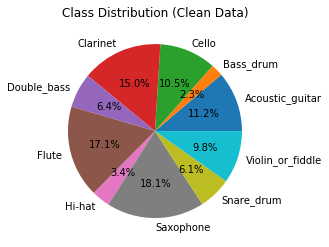

In [16]:
categories = list(np.unique(df.label))
categories_dist = df.groupby(["label"])["length"].mean()

fig, ax = plt.subplots()
ax.set_title("Class Distribution (Clean Data)")
ax.pie(categories_dist, labels=categories_dist.index, autopct="%0.1f%%")

plt.show()

In [17]:
df.to_csv(TRAIN_CSV)